In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

### Data Exploration

In [3]:
train_data = pd.read_csv('train_s3TEQDk.csv')
test_data = pd.read_csv('test_mSzZ8RL.csv')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
ID                     245725 non-null object
Gender                 245725 non-null object
Age                    245725 non-null int64
Region_Code            245725 non-null object
Occupation             245725 non-null object
Channel_Code           245725 non-null object
Vintage                245725 non-null int64
Credit_Product         216400 non-null object
Avg_Account_Balance    245725 non-null int64
Is_Active              245725 non-null object
Is_Lead                245725 non-null int64
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
ID                     105312 non-null object
Gender                 105312 non-null object
Age                    105312 non-null int64
Region_Code            105312 non-null object
Occupation             105312 non-null object
Channel_Code           105312 non-null object
Vintage                105312 non-null int64
Credit_Product         92790 non-null object
Avg_Account_Balance    105312 non-null int64
Is_Active              105312 non-null object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


In [6]:
test_data.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000000,105312.000000,1.053120e+05
mean,43.871002,46.842819,1.134195e+06
std,14.872890,32.273634,8.662430e+05
min,24.000000,7.000000,2.259700e+04
25%,30.000000,20.000000,6.039822e+05
50%,43.000000,32.000000,8.966345e+05
75%,54.000000,73.000000,1.371598e+06
max,85.000000,135.000000,9.908858e+06


In [7]:
train_data.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


#### Observations:
- Credit_Product has missing values in both train and test datasets.
- Age of the customer range from 23 to 85 with mean value of 43 years.
- Vintage range from 7 months to 135 months with mean of 47 months
- Account balance is not very comprehensible. Scaling it down using log scale might help.

In [8]:
train_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


### Exploring target Variable 

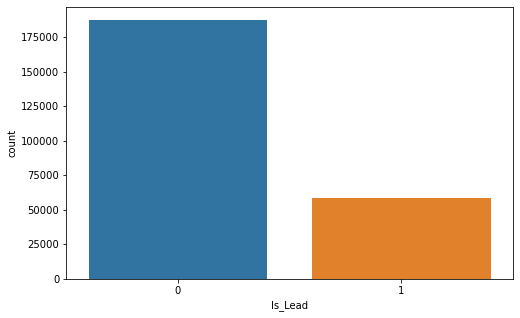

In [9]:
f = plt.figure(figsize=(8,5))
sns.countplot(x='Is_Lead', data=train_data)
plt.show()

In [10]:
train_data['Is_Lead'].value_counts(normalize=True)*100

0    76.279174
1    23.720826
Name: Is_Lead, dtype: float64

### Is_Lead seems to be skewed. The data set is  imbalanced. Will deal with it later at the pre-processing phase

## Exploring continuous variables 

### Age

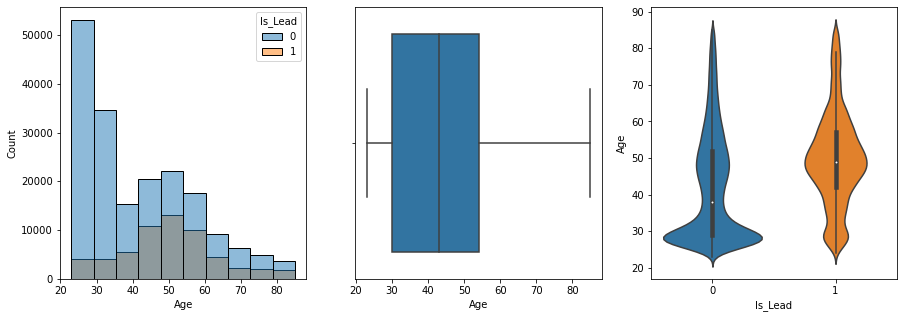

In [11]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(x=train_data['Age'], ax=axs[0], bins=10, hue='Is_Lead', data=train_data)
sns.boxplot(x='Age',data=train_data, ax=axs[1])
sns.violinplot(y = 'Age', x = 'Is_Lead', data = train_data, ax=axs[2])
plt.show()

### Observation
- There are no outliers in the age column
- Mean age is around 43.
- The mean age is higher in case of Lead.
- It seems that the customer with age between 45-55 are better Leads
- Age column can be binned into separate categories.

### Avg_Account_Balance

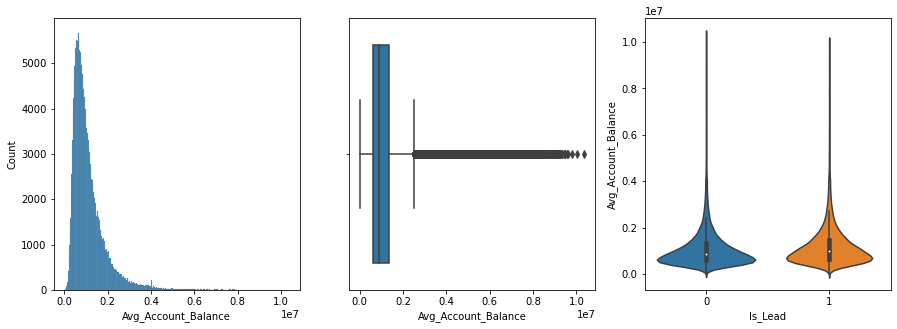

In [12]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(x=train_data['Avg_Account_Balance'], ax=axs[0])
sns.boxplot(x='Avg_Account_Balance',data=train_data, ax=axs[1])
sns.violinplot(y = 'Avg_Account_Balance', x = 'Is_Lead', data = train_data, ax=axs[2])
plt.show()

### Observation
- There are outliers in the account balance column. It looks right skewed.
- Log tranformation can help to reduce the skewness and noise.
- The mean account balance is almost same in case of Lead or Not Lead.

### Vintage

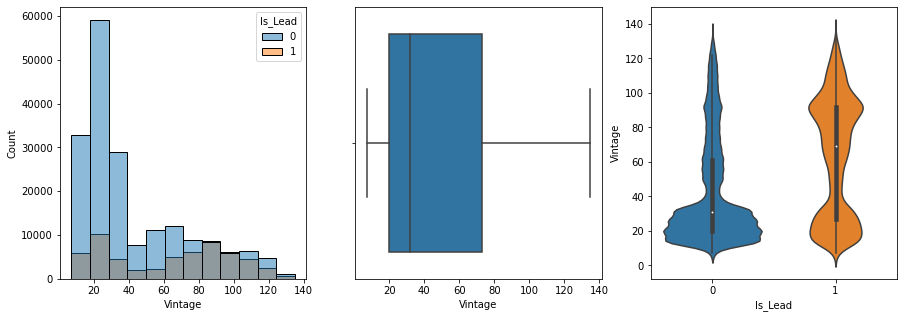

In [13]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(x='Vintage', ax=axs[0], bins=12, hue='Is_Lead', data=train_data)
sns.boxplot(x='Vintage',data=train_data, ax=axs[1])
sns.violinplot(y = 'Vintage', x = 'Is_Lead', data = train_data, ax=axs[2])
plt.show()

### Observation
- There are no outliers in the age column
- Mean Vintage age is around 25 months.
- The mean Vinatge value is higher in case of Lead.
- The vintage describes how old the customer has realtionship with the bank.
    The vinatge customers 22-30 months between 80-90 months are better Leads

### Exploring Categorical variables

In [14]:
train_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [15]:
categorical = [col for col in train_data.drop('Is_Lead', axis=1).columns if train_data[col].nunique()<50]
print(categorical)

['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']


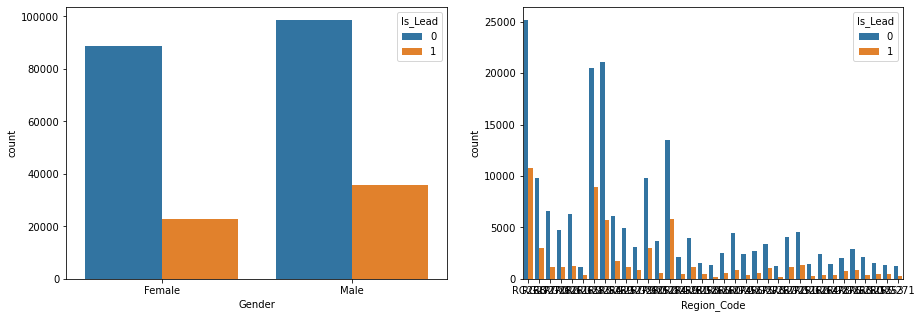

In [16]:
fig, axs =plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='Gender',data=train_data, hue='Is_Lead', ax=axs[0])
sns.countplot(x='Region_Code',data=train_data, hue='Is_Lead', ax=axs[1])


Gender is evenly distributed

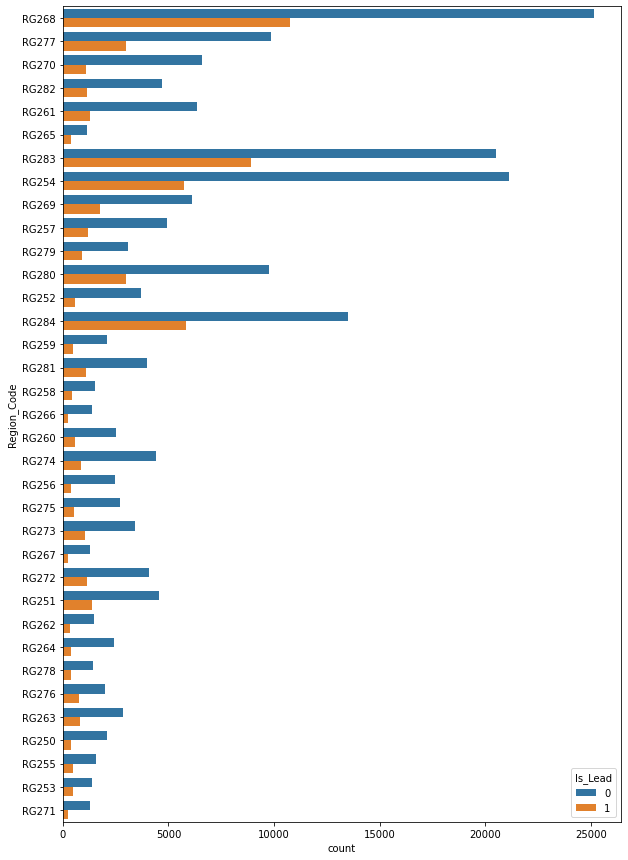

In [17]:
fig, ax =plt.subplots(figsize=(10,15))
sns.countplot(y='Region_Code',data=train_data, hue='Is_Lead', ax=ax, orient='v')

#### Few region codes have higher number of leads. This could be a good feature for our prediction

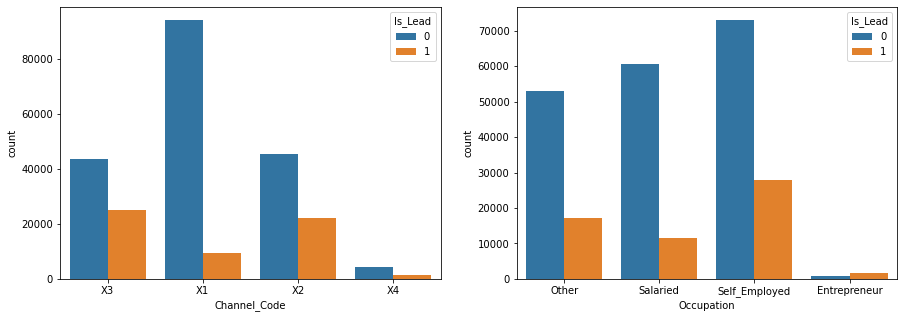

In [18]:
fig, axs =plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='Channel_Code',data=train_data, hue='Is_Lead', ax=axs[0])
sns.countplot(x='Occupation',data=train_data, hue='Is_Lead', ax=axs[1])

### Channel Code X1 has very less lead ratio. X3 is maximum

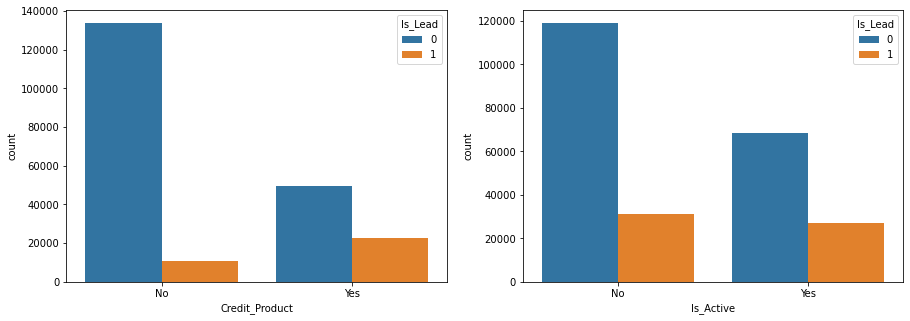

In [19]:
fig, axs =plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='Credit_Product',data=train_data, hue='Is_Lead', ax=axs[0])
sns.countplot(x='Is_Active',data=train_data, hue='Is_Lead', ax=axs[1])

##### We have already observed earlier that Credit Prouct has lot of missing values

##### We will impute these values as 'Unknown' as see the plot again

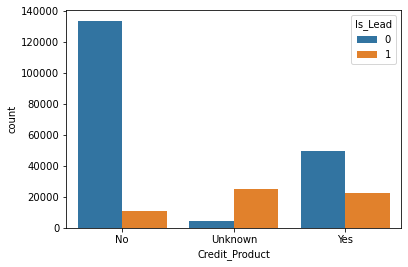

In [20]:
train_data = train_data.fillna("Unknown")
sns.countplot(x='Credit_Product',data=train_data, hue='Is_Lead')

### The Unknown category has most lead conversion ratio. This will play an important role in the prediction.

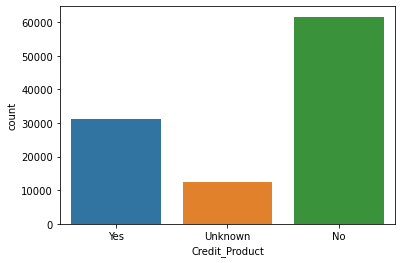

In [21]:
test_data = test_data.fillna("Unknown")
sns.countplot(x='Credit_Product',data=test_data)

#### Test data also has significant amount of Unknown catergory in Credit Product

## Data Pre-processing and Feature Engineering

#### Performing label encoding for categorical variables

In [22]:
train_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [23]:
print(categorical)

['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']


##### First I have encoded the binary categorical variables, ie,  Gender and Is_Active

In [24]:
def encode_binary_vars(dname='train'):
    le = LabelEncoder()
    if (dname == 'train'):
        train_data['Gender'] = le.fit_transform(train_data['Gender'])
        train_data['Is_Active'] = le.fit_transform(train_data['Is_Active'])
    else:
        test_data['Gender'] = le.fit_transform(test_data['Gender'])
        test_data['Is_Active'] = le.fit_transform(test_data['Is_Active'])

In [25]:
encode_binary_vars('train')
encode_binary_vars('test')

In [26]:
def one_hot_encode(dname='train'):
    if (dname == 'train'):
        data = pd.get_dummies(data=train_data, drop_first=True,
                           columns=['Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product'])
    else:
        data = pd.get_dummies(data=test_data, drop_first=True,
                           columns=['Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product'])
    return data

In [27]:
test_data = one_hot_encode('test') 
train_data = one_hot_encode('train')
train_data.head()

,ID,Gender,Age,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,...,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Unknown,Credit_Product_Yes
0,NNVBBKZB,0,73,43,1045696,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,IDD62UNG,0,30,32,581988,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,HD3DSEMC,0,56,26,1484315,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,BF3NC7KV,1,34,19,470454,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,TEASRWXV,0,30,33,886787,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Handling Age, Vintage and Avg_Account_Balance

In [28]:
def convert_continuous_columns(dname):
    if dname == 'train':
        train_data['Age']=pd.cut(x=train_data['Age'], bins=[20,30,40,50,60,100], labels=['20','30','40','50','60'])
        train_data['Age'] = train_data['Age'].astype(int)
        train_data['Vintage'] = train_data['Vintage']//12
        train_data['Avg_Account_Balance'] = np.log10(train_data['Avg_Account_Balance'])
    else:
        test_data['Age']=pd.cut(x=test_data['Age'], bins=[20,30,40,50,60,100], labels=['20','30','40','50','60'])
        test_data['Age'] = test_data['Age'].astype(int)
        test_data['Vintage'] = test_data['Vintage']//12
        test_data['Avg_Account_Balance'] = np.log10(test_data['Avg_Account_Balance'])

In [29]:
convert_continuous_columns('test')
convert_continuous_columns('train')

In [30]:
train_data.head()

,ID,Gender,Age,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,...,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Unknown,Credit_Product_Yes
0,NNVBBKZB,0,60,3,6.019405,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,IDD62UNG,0,20,2,5.764914,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,HD3DSEMC,0,50,2,6.171526,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,BF3NC7KV,1,30,1,5.672517,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,TEASRWXV,0,20,2,5.947819,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


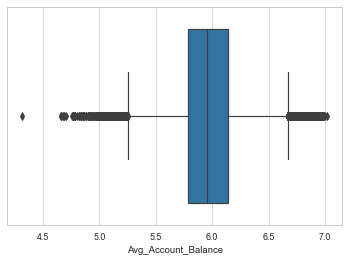

In [78]:

sns.boxplot(x='Avg_Account_Balance',data=train_data)

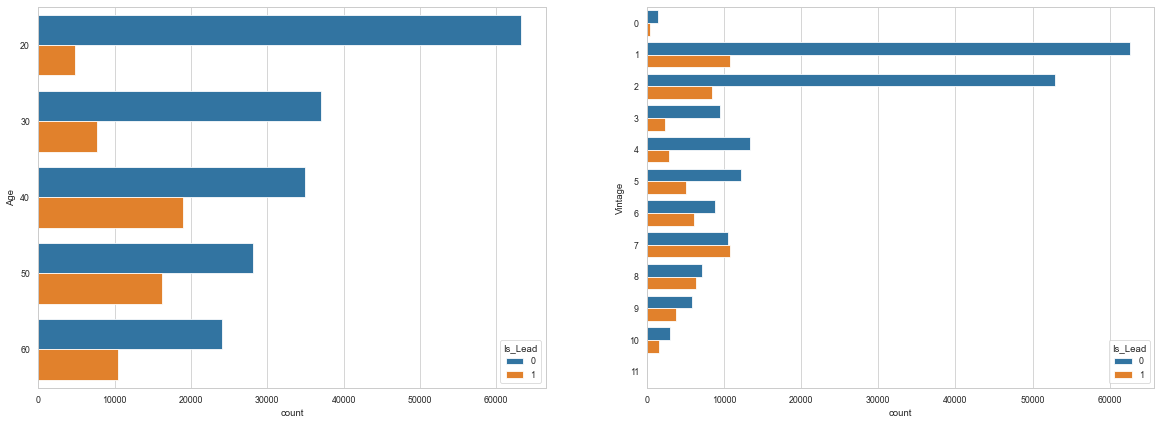

In [74]:
fig, ax =plt.subplots(1,2,figsize=(20,7))
sns.countplot(y='Age',data=train_data, hue='Is_Lead', ax=ax[0], orient='v')
sns.countplot(y='Vintage',data=train_data, hue='Is_Lead', ax=ax[1], orient='v')

In [31]:
# plt.figure(figsize=(30, 40))
# heatmap = sns.heatmap(train_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Modelling

In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 49 columns):
ID                          245725 non-null object
Gender                      245725 non-null int32
Age                         245725 non-null int32
Vintage                     245725 non-null int64
Avg_Account_Balance         245725 non-null float64
Is_Active                   245725 non-null int32
Is_Lead                     245725 non-null int64
Region_Code_RG251           245725 non-null uint8
Region_Code_RG252           245725 non-null uint8
Region_Code_RG253           245725 non-null uint8
Region_Code_RG254           245725 non-null uint8
Region_Code_RG255           245725 non-null uint8
Region_Code_RG256           245725 non-null uint8
Region_Code_RG257           245725 non-null uint8
Region_Code_RG258           245725 non-null uint8
Region_Code_RG259           245725 non-null uint8
Region_Code_RG260           245725 non-null uint8
Region_Code_RG261           245725 n

In [33]:
y = train_data['Is_Lead']
X = train_data.drop(['Is_Lead', 'ID'], axis=1)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101, stratify=y)

### Since the dataset is imbalanced, i have used the scale_pos_weight parameter of xgboost to let the model handle the class imbalance.

In [35]:
scale_post_wt = (len(y_train)-sum(y_train))/sum(y_train)
scale_post_wt

3.2157409393094576

In [36]:
import xgboost as xgb

param_dist = {'learning_rate' :0.1,
             'n_estimators':200,
             'max_depth':6,
             'min_child_weight':2,
             'gamma':0.8,
              'reg_lambda':1,
             'subsample':0.5,
             'colsample_bytree':0.8,
             'objective': 'binary:logistic',
             'nthread':4,
             'scale_pos_weight': scale_post_wt,
             'seed':42}

clf = xgb.XGBClassifier(**param_dist)

clf.fit(X_train, y_train,
       eval_set=[(X_train, y_train),(X_test, y_test)],
          eval_metric='auc',
         early_stopping_rounds=20,
        verbose=True)

C:\Users\mgaurav\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.82945	validation_1-auc:0.82933
[1]	validation_0-auc:0.86814	validation_1-auc:0.86824
[2]	validation_0-auc:0.86469	validation_1-auc:0.86541
[3]	validation_0-auc:0.86880	validation_1-auc:0.86918
[4]	validation_0-auc:0.86967	validation_1-auc:0.87017
[5]	validation_0-auc:0.86931	validation_1-auc:0.86972
[6]	validation_0-auc:0.87026	validation_1-auc:0.87091
[7]	validation_0-auc:0.87030	validation_1-auc:0.87052
[8]	validation_0-auc:0.87074	validation_1-auc:0.87104
[9]	validation_0-auc:0.87156	validation_1-auc:0.87188
[10]	validation_0-auc:0.87194	validation_1-auc:0.87213
[11]	validation_0-auc:0.87213	validation_1-auc:0.87220
[12]	validation_0-auc:0.87247	validation_1-auc:0.87255
[13]	validation_0-auc:0.87274	validation_1-auc:0.87279
[14]	validation_0-auc:0.87266	validation_1-auc:0.87268
[15]	validation_0-auc:0.87295	validation_1-auc:0.87291
[16]	validation_0-auc:0.87315	validation_1-auc:0.87308
[17]	validation_0-auc:0.87322	validation_1-auc:0.87309
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.8, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.2157409393094576, seed=42, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

Text(0.5, 0, 'Xgboost Feature Importance')

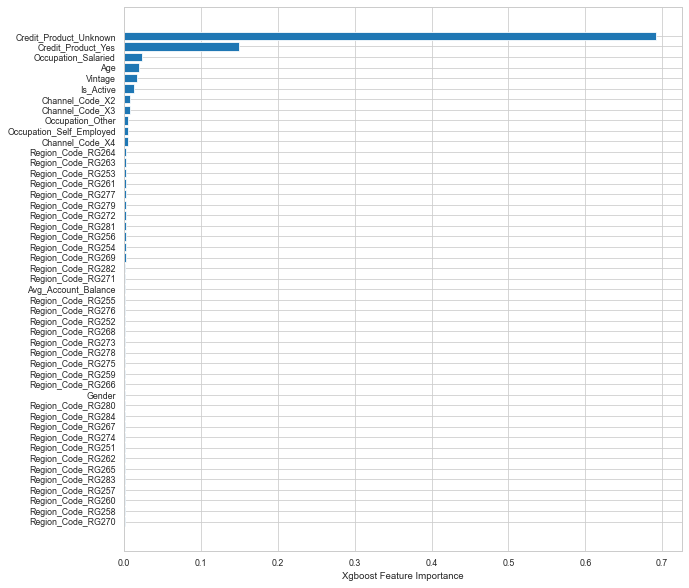

In [64]:
fig, ax =plt.subplots(figsize=(10,10))
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

#### This parameters for the above  model  was selected after manual tuning and hyperparameter tuning using RandomSearchCV. 

The average train and test scores are very close, validation_0-auc:0.87960	validation_1-auc:0.87406 respectively. This shows that the model is not overfittinng and it will generalize well on the unseen data

In [37]:
predictions = clf.predict_proba(X_test)[:,1]
print('AUC Score:',roc_auc_score(y_test, predictions))

AUC Score: 0.8742645812188301


In [38]:
# calculate roc curves
def plot_roc_auc_curve():
    avg_predictions = [0 for _ in range(len(y_test))]
   
    av_auc = roc_auc_score(y_test, avg_predictions)
    gb_auc = roc_auc_score(y_test, predictions)
    # summarize scores
    print('Avg Model: ROC AUC=%.3f' % (av_auc))
    print('XGBoost  : ROC AUC=%.3f' % (gb_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, avg_predictions)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, predictions)
    # plot the roc curve for the model
    fig, ax =plt.subplots(figsize=(10,5))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Average')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='XG BOOST')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

Avg Model: ROC AUC=0.500
XGBoost  : ROC AUC=0.874


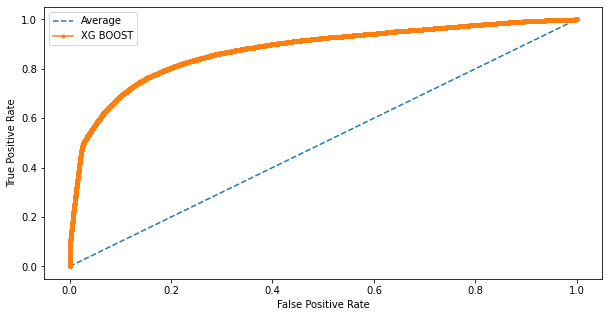

In [39]:
plot_roc_auc_curve()

In [40]:
y_pred_df = pd.DataFrame({'Converted':y_test.values, 'Lead_Probability':predictions})
y_pred_df['Lead_Score'] = round((y_pred_df['Lead_Probability'] * 100),0)
y_pred_df['Predicted_Hot_Lead'] = y_pred_df.Lead_Probability.map(lambda x: 1 if x > 0.5 else 0)
y_pred_df.head()

,Converted,Lead_Probability,Lead_Score,Predicted_Hot_Lead
0,1,0.940758,94.0,1
1,0,0.375282,38.0,0
2,0,0.150667,15.0,0
3,0,0.147583,15.0,0
4,0,0.445747,45.0,0


In [41]:
conf_mat = confusion_matrix(y_test, y_pred_df.Predicted_Hot_Lead )
print(conf_mat)

[[31270  6217]
 [ 2627  9031]]


In [42]:
TP = conf_mat[1,1] # true positive 
TN = conf_mat[0,0] # true negatives
FP = conf_mat[0,1] # false positives
FN = conf_mat[1,0] # false negatives

In [43]:
sensitivity = round((TP / float(TP+FN)),2)
specificity = round((TN / float(TN+FP)),2)

print('Sensitivity is {}% and Specificity is {}%'.format(sensitivity*100, specificity*100))

Sensitivity is 77.0% and Specificity is 83.0%


In [44]:
fpr, tpr, thresholds = roc_curve( y_test, y_pred_df.Predicted_Hot_Lead, drop_intermediate = False )

In [45]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_df[i]= y_pred_df.Lead_Probability.map(lambda x: 1 if x > i else 0)
y_pred_df.head()

,Converted,Lead_Probability,Lead_Score,Predicted_Hot_Lead,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.940758,94.0,1,1,1,1,1,1,1,1,1,1,1
1,0,0.375282,38.0,0,1,1,1,1,0,0,0,0,0,0
2,0,0.150667,15.0,0,1,1,0,0,0,0,0,0,0,0
3,0,0.147583,15.0,0,1,1,0,0,0,0,0,0,0,0
4,0,0.445747,45.0,0,1,1,1,1,1,0,0,0,0,0


In [46]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['Probability','Accuracy','Sensitivity','Specificty', 'Precision'])

cuoffs = [float(x)/10 for x in range(10)]
for i in cuoffs:
    cm1 = confusion_matrix(y_test, y_pred_df[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    preci = cm1[1,1]/(cm1[1,1]+cm1[0,1])   #TP/TP+FP
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci, preci]   
print(cutoff_df)

     Probability  Accuracy  Sensitivity  Specificty  Precision
0.0          0.0  0.237216     1.000000    0.000000   0.237216
0.1          0.1  0.300560     0.993652    0.085016   0.252463
0.2          0.2  0.636240     0.913107    0.550137   0.386964
0.3          0.3  0.735273     0.864985    0.694934   0.468587
0.4          0.4  0.777861     0.829988    0.761651   0.519908
0.5          0.5  0.820043     0.774661    0.834156   0.592274
0.6          0.6  0.845172     0.706982    0.888148   0.662807
0.7          0.7  0.857747     0.627552    0.929336   0.734170
0.8          0.8  0.860617     0.504289    0.971430   0.845899
0.9          0.9  0.856242     0.469720    0.976445   0.861142


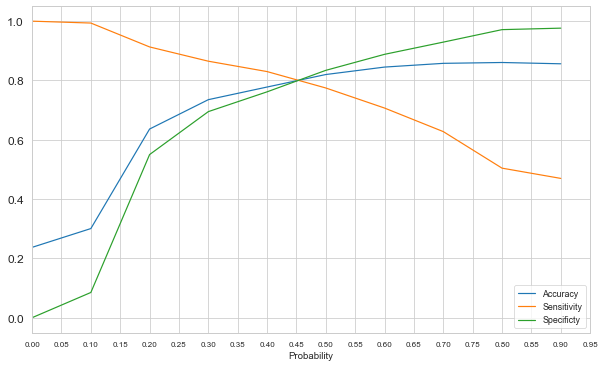

In [47]:
sns.set_style('whitegrid')
sns.set_context('paper')

cutoff_df.plot.line(x='Probability', y=['Accuracy','Sensitivity','Specificty'], figsize=(10,6))
plt.xticks(np.arange(0,1,step=.05), size=8)
plt.yticks(size=12)
plt.show()

###### As you can see, at about a threshold of 0.45, the curves of accuracy, sensitivity and specificity intersect, and they all take a value of around 80%. With this threshold we will predict the Hot Lead again.

In [48]:
cut_off=0.45
y_pred_df['Predicted_Hot_Lead'] = y_pred_df.Lead_Probability.map( lambda x: 1 if x > cut_off else 0)
y_pred_df.head()

,Converted,Lead_Probability,Lead_Score,Predicted_Hot_Lead,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.940758,94.0,1,1,1,1,1,1,1,1,1,1,1
1,0,0.375282,38.0,0,1,1,1,1,0,0,0,0,0,0
2,0,0.150667,15.0,0,1,1,0,0,0,0,0,0,0,0
3,0,0.147583,15.0,0,1,1,0,0,0,0,0,0,0,0
4,0,0.445747,45.0,0,1,1,1,1,1,0,0,0,0,0


In [49]:
conf_mat = confusion_matrix(y_test, y_pred_df.Predicted_Hot_Lead )
print(conf_mat)

[[30376  7111]
 [ 2387  9271]]


In [50]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
m={}
actual = y_test
predicted = y_pred_df.Predicted_Hot_Lead
confusion = confusion_matrix(actual, predicted )
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
m['sensitivity']=TP / float(TP+FN)
m['specificity']=TN / float(TN+FP)
m['recall']=recall_score(actual, predicted)
m['precision']=precision_score(actual, predicted)
m['accuracy']=accuracy_score(actual, predicted)
m['F1-score']=f1_score(actual, predicted, average='weighted')

print(confusion)
for metric in m:
    print(metric + ': ' + str(round(m[metric],2)))

[[30376  7111]
 [ 2387  9271]]
sensitivity: 0.8
specificity: 0.81
recall: 0.8
precision: 0.57
accuracy: 0.81
F1-score: 0.82


The F1-Score for this model is 0.82, which is pretty decent score.

### The customers with high lead score probability must be first contacted by the bank as they are more likely to take the credit cards or other bank products

### Train the final model on whole train data and create the  submission file

In [51]:
X.shape

(245725, 47)

In [52]:
import xgboost as xgb

param_dist = {'learning_rate' :0.1,
             'n_estimators':100,
             'max_depth':6,
             'min_child_weight':2,
             'gamma':0.8,
              'reg_lambda':1,
             'subsample':0.5,
             'colsample_bytree':0.8,
             'objective': 'binary:logistic',
             'nthread':4,
             'scale_pos_weight': scale_post_wt,
             'seed':42}

clf = xgb.XGBClassifier(**param_dist)

clf.fit(X, y,
          eval_metric='auc')

C:\Users\mgaurav\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.8, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.2157409393094576, seed=42, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
test_data.head()

,ID,Gender,Age,Vintage,Avg_Account_Balance,Is_Active,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,...,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Unknown,Credit_Product_Yes
0,VBENBARO,1,20,2,5.870618,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,CCMEWNKY,1,40,4,5.966394,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,VK3KGA9M,1,30,1,5.334351,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,TT8RPZVC,1,20,2,5.938555,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,SHQZEYTZ,0,20,1,5.817623,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [54]:
test_data_id = test_data['ID']
test_data.drop('ID', inplace=True, axis=1)
predictions = clf.predict_proba(test_data)[:,1]

submission = pd.DataFrame({'ID':test_data_id, 'Is_Lead':predictions})
submission.to_csv('xgboost_submission_final.csv', index=False)